<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/Lab3/strip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use STRIP method to detect the backdoored images. Here, we need to calculate the entropy and set a threshold. If the entropy of a new given input is greater than this threshold, then it means it is a clean input, and backdoored input otherwise.  

## Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
import cv2
import scipy
import scipy.stats
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
clean_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/valid.h5'
poisoned_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_valid.h5'
model_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Model/bd_net.h5'

In [5]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

Load model

In [4]:
model = keras.models.load_model(model_filename)

Get data

In [6]:
x_data, y_data = data_loader(clean_data_filename)
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

In [8]:
print(x_data.shape)

(11547, 55, 47, 3)


superimpose, it used to combine two images

In [10]:
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(55,47,3))

It uses to calculate the entropy for each input. It will return a number that is not normalized.

In [27]:
def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(10000,11547, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_data[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

We try to get the entropy_benigh (get the entropy from clean data input) and entropy_trojan (get the entropy from poisoned data). Here, we have 11547 validation data. We pick 3000 images from first 10,000 and 100 images from the last 1547 as.....

In [28]:
n_test = 3000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_data[j] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = x_poisoned_data[j]
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


1000
0
1000


In [67]:
print(entropy_benigh)
print(entropy_trojan)

[0.26166032791137694, 0.2767320251464844, 0.24593589782714845, 0.28694995880126956, 0.17923099517822266, 0.3019680976867676, 0.2387528419494629, 0.26168846130371093, 0.26292230606079103, 0.2510831260681152, 0.32213237762451175, 0.14953133583068848, 0.35681278228759766, 0.31808488845825195, 0.26879817962646485, 0.2114577102661133, 0.34414180755615237, 0.22463407516479492, 0.4058139419555664, 0.3981997680664062, 0.22058788299560547, 0.27182525634765625, 0.33352901458740236, 0.21804628372192383, 0.27712713241577147, 0.26471107482910156, 0.25603691101074216, 0.012172262668609619, 0.23285120010375976, 0.22887418746948243, 0.28793149948120117, 0.2602790069580078, 0.28005510330200195, 0.24536319732666015, 0.22897262573242189, 0.3190206527709961, 0.28850669860839845, 0.28791170120239257, 0.25165605545043945, 0.2824952507019043, 0.18967470169067382, 0.23598382949829103, 0.191481990814209, 0.3646714401245117, 0.2304534149169922, 0.1995969009399414, 0.2900403022766113, 0.24657657623291016, 0.1849

Normalized the entropy

In [30]:
entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

Visualize the probability distribution for clean input and poisoned data. 

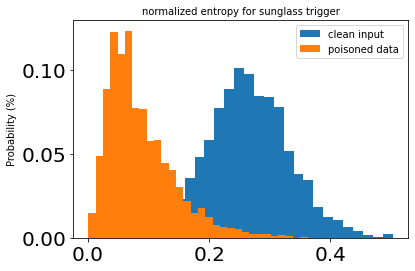

In [35]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='clean input')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='poisoned data')
plt.legend(loc='upper right', fontsize = 10)
plt.ylabel('Probability (%)', fontsize = 10)
plt.title('normalized entropy for sunglass trigger', fontsize = 10)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist.svg')# save the fig as pdf file

One way to find the threshold. We need to find a threshold that make as much poisoned data being less than the threshold as possilble and make as much clean data being greather than the thresold as possible.

In [98]:
(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print("μ is: {}, σ is: {}".format(mu, sigma))

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print("threshold is: ", threshold)

FAR = sum(i > 0.17 for i in entropy_trojan)
temp = sum(i < 0.17 for i in entropy_benigh)
print(FAR/2000*100) #reproduce results in Table 3 of our paper
print(temp/2000*100) #reproduce results in Table 3 of our paper

μ is: 0.262483966242075, σ is: 0.07041650520276961
threshold is: {} 0.09867067906622609
8.450000000000001
8.9


In [33]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs

0.012172262668609619
0.3628378677368164


In [91]:
x_FAR = np.linspace(0.012172262668609619,0.3628378677368164,100)
y_FAR = []
y_temp = []
for i in x_FAR:
  y_FAR.append(sum(j < i for j in entropy_trojan)/2000*100)
  y_temp.append(sum(j > i for j in entropy_benigh)/2000*100)

In [ ]:
x_FAR = np.linspace(0.012172262668609619,0.3628378677368164,100)
print(x_FAR)

We can actually visualize the normalized entropy_clean v.s. entropy_poisoned to find the best threshold.  

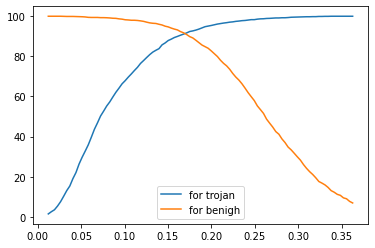

In [92]:
plt.plot(x_FAR, y_FAR)
plt.plot(x_FAR, y_temp)
plt.legend(['for trojan', 'for benigh'])

Here, we will use the test data to see the accuracy of the clean data input and attack success rate for poisoned data 

In [36]:
test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/clean/test.h5'
poisoned_test_data_filename = '/content/gdrive/MyDrive/ECE-GY 9163/Lab3/Data/bd/bd_test.h5'

In [37]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [ ]:
x_test_data = x_test_data.astype('float64')
x_test_poisoned_data = x_test_poisoned_data.astype('float64')

predictive function

In [94]:
def entropyCal_pred(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(10000,11547, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_data[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))/n
  if EntropySum > 0.17:
    test_label_p = np.argmax(model.predict(background.reshape(-1,55,47,3)), axis=1)
    return test_label_p
  return 1283
  

In [95]:
pred_clean = [0] * x_test_data.shape[0]
pred_poison = [0] * x_test_data.shape[0]
for j in range(x_test_data.shape[0]):
  if 0 == j%1000:
    print("Already tested {} images".foramt(j))
  x_background = x_test_data[j] 
  pred_clean[j] = entropyCal_pred(x_background, 100)
  x_poison = x_test_poisoned_data[j]
  pred_poison[j] = entropyCal_pred(x_poison, 100)

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


0


In [96]:
print(sum(i==1283 for i in pred_poison))

[85]


In [97]:
clean_accuracy = np.mean(np.equal(pred_clean, y_test_data[0:100]))*100
print('Clean Classification accuracy:', clean_accuracy)

Clean Classification accuracy: 92.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [100]:
asr = np.mean(np.equal(pred_poison, y_test_poisnoed_data[0:100]))*100
print('Attack Success Rate:', asr)

Attack Success Rate: 15.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
